In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib
from scipy import stats, optimize

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue_taylor.adjusters.adjust_annular import (set_init_point, prepare_tensions, adjust_tensions,
                                                    adjust_areas, adjust_scale)
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model, lumen_area_grad, create_organo
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces, _coef_matrix, _right_side
from tyssue_taylor.models.display import (print_tensions, rendering_results,
                                          rendering_convergence_results,
                                          plot_force_inference)

Error: IPOPT shared library failed to import


Using TensorFlow backend.


ImportError: cannot import name 'create_organo'

In [8]:
nb_cells = 3
r_in = 1
r_out = 4

In [9]:
organo = generate_ring(nb_cells, r_in, r_out)
Nf= organo.Nf
geom.update_all(organo)
#alpha as proposed in the doc (in french) https://www.sharelatex.com/read/zdxptpnrryhc
alpha = 1 + 1/(20*(organo.settings['R_out']-organo.settings['R_in']))


# Model parameters or specifications
specs = {
    'face':{
        'is_alive': 1,
        'prefered_area':  alpha*organo.face_df.area, 
        'area_elasticity': 1.,},
    'edge':{        
        'ux': 0.,
        'uy': 0.,
        'uz': 0.,
        'line_tension': 0.001,
        'is_active': 1
        },
    'vert':{
        'adhesion_strength': 0.,
        'x_ecm': 0.,
        'y_ecm': 0.,
        'is_active': 1
        },
    'settings': {
        'lumen_elasticity': 0.1,
        'lumen_prefered_vol': organo.settings['lumen_volume']*1.1,
        'lumen_volume': organo.settings['lumen_volume']
        }
    }

organo.update_specs(specs, reset=True)
organo.edge_df.loc[:nb_cells, 'line_tension'] *= 2
organo.edge_df.loc[nb_cells:2*nb_cells, 'line_tension'] = 0
organo.vert_df.loc[:, 'x'] = (organo.vert_df.x.copy() * np.cos(np.pi/12) -
                              organo.vert_df.y.copy() * np.sin(np.pi/12))
organo.vert_df.loc[:, 'y'] = (organo.vert_df.x.copy() * np.sin(np.pi/12) +
                              organo.vert_df.y.copy() * np.cos(np.pi/12))
normalize_scale(organo, geom, refer='edges')
geom.update_all(organo)
Solver.find_energy_min(organo, geom, model)

Reseting datasets values with new specs


      fun: 0.0033854257013824973
 hess_inv: <12x12 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.22057075e-04, -2.61731733e-04, -2.55412710e-04,  2.11417471e-04,
        1.17348556e-05,  1.52520588e-04, -6.75476118e-04,  5.55266849e-04,
        3.77253655e-04, -4.65670674e-05, -8.01567569e-05, -6.10906108e-04])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 2
      nit: 1
   status: 0
  success: True
        x: array([ 0.19143477, -0.17679687, -0.26198704, -0.06777193,  0.07022676,
        0.24494021,  0.77609239, -0.71791077, -1.05961867, -0.27443538,
        0.28385179,  0.99197474])

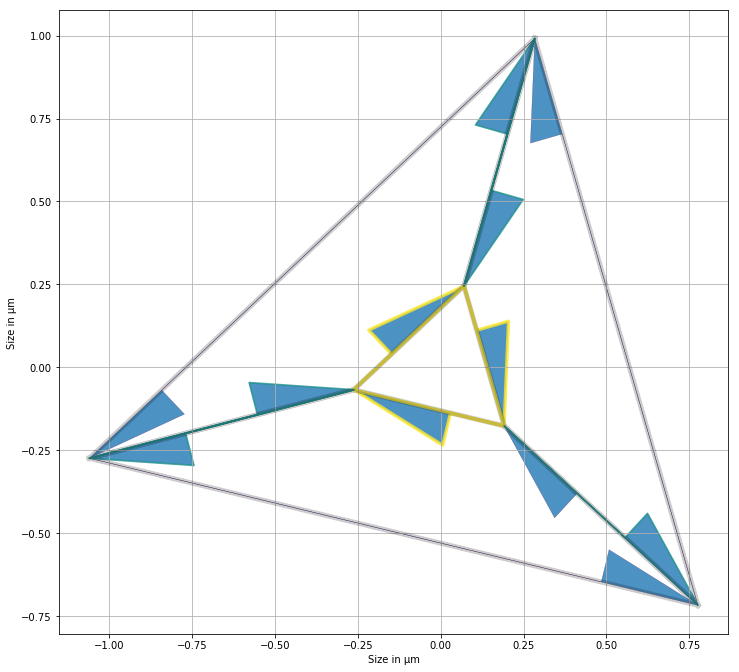

In [10]:
print_tensions(organo, organo)

In [13]:
coefs = _coef_matrix(organo, 'areas')
cmap = plt.cm.get_cmap('tab20')

Aire de la cellule 1:  0.4569272776268928


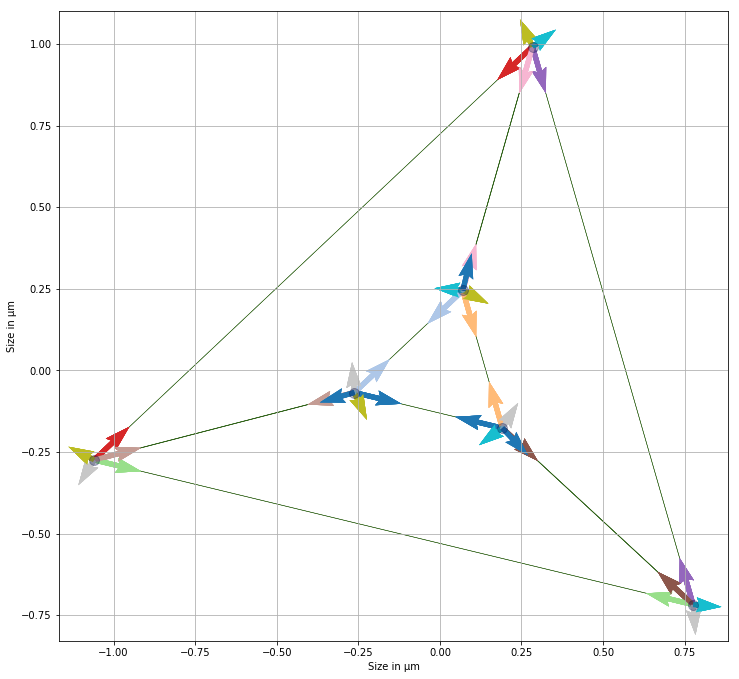

In [14]:
U = np.concatenate([coefs[i][coefs[i] != 0]
                    for i in range(organo.Nv)])
V = np.concatenate([coefs[i+6][coefs[i+6] != 0]
                    for i in range(organo.Nv)])
X = np.concatenate([[organo.vert_df.x[i]]*len(coefs[i][coefs[i] != 0])
                    for i in range(organo.Nv)])
Y = np.concatenate([[organo.vert_df.y[i]]*len(coefs[i][coefs[i] != 0])
                    for i in range(organo.Nv)])
C = np.concatenate([np.argwhere(coefs[i] != 0)
                    for i in range(organo.Nv)])
draw_specs = sheet_spec()
draw_specs['edge']['head_width'] = 0
cmap = plt.cm.get_cmap(cmap)
fig, ax = sheet_view(organo, **draw_specs)
for i in range(organo.Nv):
    q = ax.quiver(X, Y, U, V, C, cmap=cmap)
    ax.quiverkey(q, X=0.3, Y=1.1, U=10,
                 label='Quiver key, length = 10', labelpos='E')

U = np.array([coefs[i][-1][coefs[i][-1]!=0] for i in range(3)])
V = np.array([coefs[i+6][-1][coefs[i+6][-1]!=0] for i in range(3)])
X = organo.vert_df.loc[organo.apical_edges, 'x']
Y = organo.vert_df.loc[organo.apical_edges, 'y']
C = [0]*3
for i in range(3):
    q = ax.quiver(X, Y, U, V, C, cmap='tab20')
    ax.quiverkey(q, X=0.3, Y=1.1, U=10,
                 label='Quiver key, length = 10', labelpos='E')
fig.set_size_inches(12, 12)
plt.xlabel('Size in µm')
plt.ylabel('Size in µm')
print("Aire de la cellule 1: ", organo.face_df.area[1])

Aire de la cellule 1:  0.4569272776268928


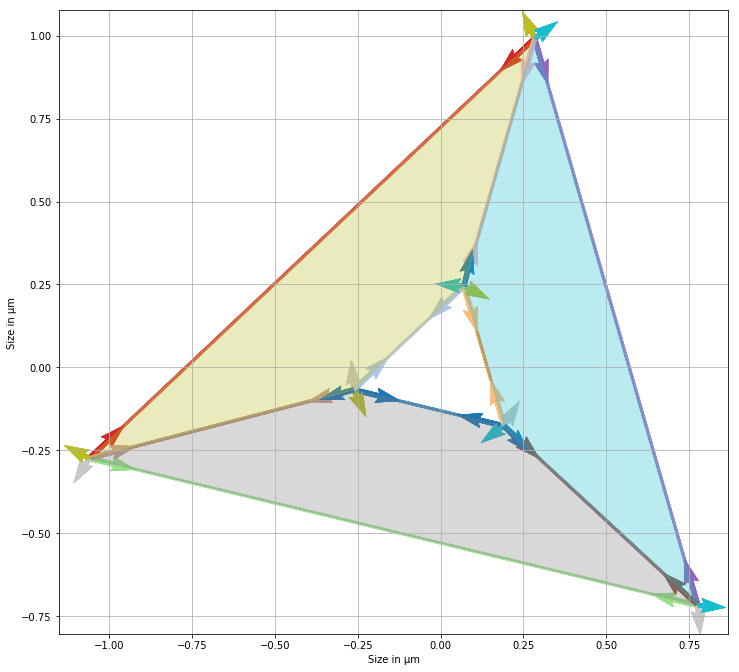

In [7]:
U = np.concatenate([coefs[i][coefs[i] != 0]
                    for i in range(organo.Nv)])
V = np.concatenate([coefs[i+6][coefs[i+6] != 0]
                    for i in range(organo.Nv)])
X = np.concatenate([[organo.vert_df.x[i]]*len(coefs[i][coefs[i] != 0])
                    for i in range(organo.Nv)])
Y = np.concatenate([[organo.vert_df.y[i]]*len(coefs[i][coefs[i] != 0])
                    for i in range(organo.Nv)])
C = np.concatenate([np.argwhere(coefs[i] != 0)
                    for i in range(organo.Nv)])
draw_specs = sheet_spec()
cmap = plt.cm.get_cmap(cmap)
edge_cmap = cmap(np.arange(20))[[0,1,2,5,6,8,13,10,11,11,13,10]]
#edge_color = np.concatenate((np.arange(organo.Nf*3), np.roll(np.arange(organo.Nf*2, organo.Nf*3), -1)))
#cmap = plt.cm.get_cmap(q.cmap)
#edge_cmap = cmap(C)
#dic = {}
#for ind in np.squeeze(C):
#    print(ind, np.squeeze(np.squeeze(edge_cmap)[ind]))
#    dic[ind] = np.squeeze(np.squeeze(edge_cmap)[ind])
#print(dic)
#edge_cmap2 = np.concatenate(([dic[ind] for ind in range(organo.Nf*3)],
#                            np.roll([dic[ind] for ind in range(organo.Nf*2, organo.Nf*3)], -1, axis=0)))
draw_specs['vert']['visible'] = False
draw_specs['edge']['colormap'] = cmap
draw_specs['edge']['color'] = edge_cmap
draw_specs['edge']['width'] = 3
draw_specs['edge']['head_width'] = 0
fig, ax = sheet_view(organo, **draw_specs)
for i in range(organo.Nv):
    q = ax.quiver(X, Y, U, V, C, cmap=cmap)
    ax.quiverkey(q, X=0.3, Y=1.1, U=10,
                 label='Quiver key, length = 10', labelpos='E')
ax.fill((organo.vert_df.loc[(0, 1, 4, 3), 'x']), organo.vert_df.loc[(0, 1, 4, 3), 'y'], alpha=0.3,
        color=cmap(np.arange(20))[14]) 
ax.fill((organo.vert_df.loc[(1, 2, 5, 4), 'x']), organo.vert_df.loc[(1, 2, 5, 4), 'y'], alpha=0.3,
        color=cmap(np.arange(20))[16]) 
ax.fill((organo.vert_df.loc[(2, 0, 3, 5), 'x']), organo.vert_df.loc[(2, 0, 3, 5), 'y'], alpha=0.3,
        color=cmap(np.arange(20))[18])

U = np.array([coefs[i][-1][coefs[i][-1]!=0] for i in range(3)])
V = np.array([coefs[i+6][-1][coefs[i+6][-1]!=0] for i in range(3)])
X = organo.vert_df.loc[organo.apical_edges, 'x']
Y = organo.vert_df.loc[organo.apical_edges, 'y']
C = [0]*3
for i in range(3):
    q = ax.quiver(X, Y, U, V, C, cmap='tab20')
    ax.quiverkey(q, X=0.3, Y=1.1, U=10,
                 label='Quiver key, length = 10', labelpos='E')
fig.set_size_inches(12, 12)
plt.xlabel('Size in µm')
plt.ylabel('Size in µm')
print("Aire de la cellule 1: ", organo.face_df.area[1])

In [159]:
cmap = plt.cm.get_cmap('tab20')
edge_cmap = cmap(np.arange(12))

[[0.12156863 0.46666667 0.70588235 1.        ]
 [0.68235294 0.78039216 0.90980392 1.        ]
 [1.         0.49803922 0.05490196 1.        ]
 [1.         0.73333333 0.47058824 1.        ]
 [0.17254902 0.62745098 0.17254902 1.        ]
 [0.59607843 0.8745098  0.54117647 1.        ]
 [0.83921569 0.15294118 0.15686275 1.        ]
 [1.         0.59607843 0.58823529 1.        ]
 [0.58039216 0.40392157 0.74117647 1.        ]
 [0.77254902 0.69019608 0.83529412 1.        ]
 [0.54901961 0.3372549  0.29411765 1.        ]
 [0.76862745 0.61176471 0.58039216 1.        ]]


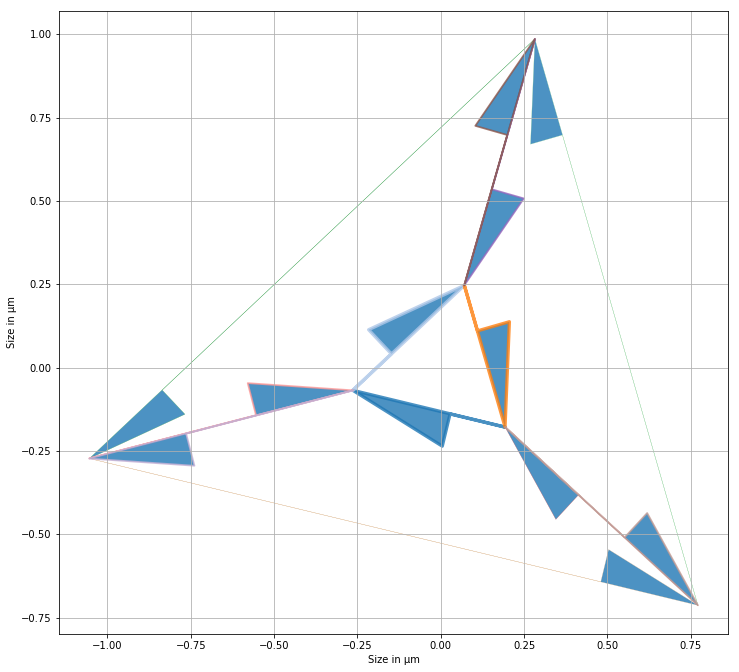

In [160]:
cmap = 'tab20'
draw_specs = sheet_spec()
tension_max = np.max(organo.edge_df.line_tension.values.copy())
ten = organo.edge_df.line_tension.values.copy()
edge_color = 1/tension_max*organo.edge_df.line_tension.values.copy()
cmap = plt.cm.get_cmap('tab20')
draw_specs['vert']['visible'] = False
draw_specs['edge']['color'] = edge_cmap
draw_specs['edge']['width'] = 0.25+3*edge_color
fig, ax = sheet_view(organo, **draw_specs)
fig.set_size_inches(12, 12)
plt.xlabel('Size in µm')
plt.ylabel('Size in µm')
print(edge_cmap)

In [7]:
coefs = _coef_matrix(organo, 'areas')
plot_force_inference(organo, coefs)

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f7d89baae18> (for post_execute):


ValueError: object too deep for desired array

ValueError: object too deep for desired array

<Figure size 864x864 with 1 Axes>

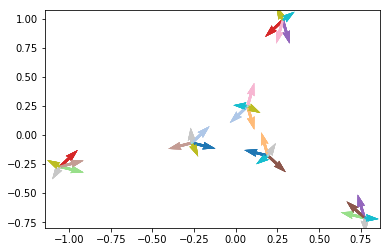

In [242]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()
U = np.concatenate([coefs[i][coefs[i]!=0] for i in range(6)])
V = np.concatenate([coefs[i+6][coefs[i+6]!=0] for i in range(6)])
X = np.concatenate([[organo.vert_df.x[i]]*len(coefs[i][coefs[i]!=0]) for i in range(6)])
Y = np.concatenate([[organo.vert_df.y[i]]*len(coefs[i][coefs[i]!=0]) for i in range(6)])
C = np.concatenate([np.argwhere(coefs[i]!=0) for i in range(6)])
for i in range(6):
    q = ax.quiver(X, Y, U, V, C, cmap='tab20')
    ax.quiverkey(q, X=0.3, Y=1.1, U=10,
                 label='Quiver key, length = 10', labelpos='E')

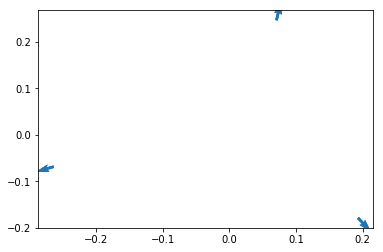

In [272]:

fig, ax = plt.subplots()
U = np.array([coefs[i][-1][coefs[i][-1]!=0] for i in range(3)])
V = np.array([coefs[i+6][-1][coefs[i+6][-1]!=0] for i in range(3)])
X = organo.vert_df.loc[organo.apical_edges, 'x']
Y = organo.vert_df.loc[organo.apical_edges, 'y']
C = [1]*3
for i in range(3):
    q = ax.quiver(X, Y, U, V, C, cmap='tab20')
    ax.quiverkey(q, X=0.3, Y=1.1, U=10,
                 label='Quiver key, length = 10', labelpos='E')

In [270]:
X

edge
0    0.192932
1   -0.263550
2    0.070618
Name: x, dtype: float64

In [266]:
lumen_coefs_u

[0.03147294989207969, -0.04248240718535643, 0.011009457293276743]

[[ 0]
 [ 2]
 [ 6]
 [ 9]
 [11]
 [12]]
[[ 0]
 [ 1]
 [ 7]
 [ 9]
 [10]
 [12]]
[[ 1]
 [ 2]
 [ 8]
 [10]
 [11]
 [12]]
[[ 3]
 [ 5]
 [ 6]
 [ 9]
 [11]]
[[ 3]
 [ 4]
 [ 7]
 [ 9]
 [10]]
[[ 4]
 [ 5]
 [ 8]
 [10]
 [11]]


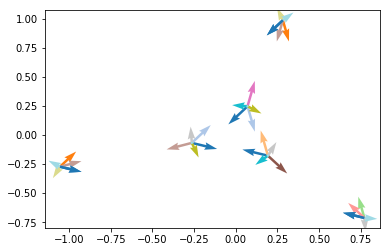

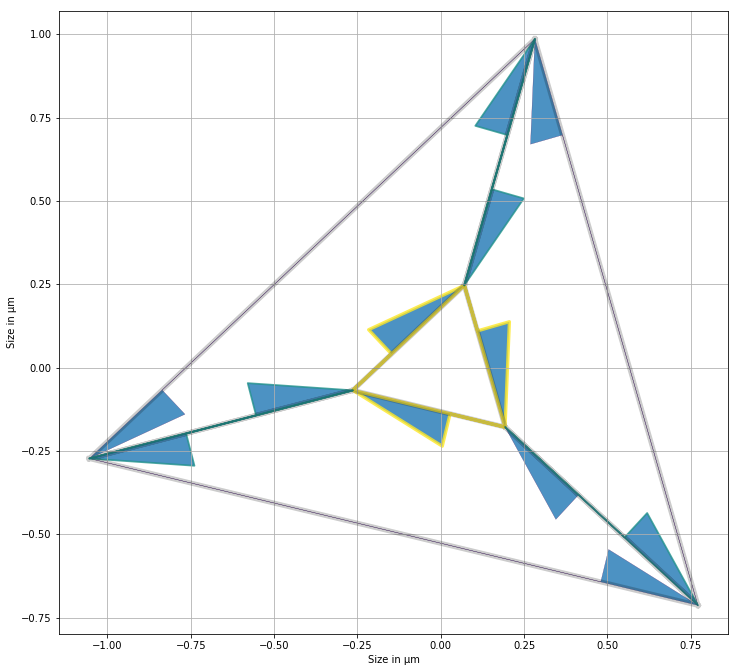

In [8]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()
print_tensions(organo, organo)
for i in range(6):
    U = coefs[i][coefs[i]!=0]
    V = coefs[i+6][coefs[i+6]!=0]
    X = [organo.vert_df.x[i]]*6
    Y = [organo.vert_df.y[i]]*6
    C = np.argwhere(coefs[i]!=0)
    print(C)
    q = ax.quiver(X, Y, U, V, C, cmap='tab20')
    ax.quiverkey(q, X=0.3, Y=1.1, U=10,
                 label='Quiver key, length = 10', labelpos='E')

In [34]:
sym_organo.vert_df.x

vert
0    3.949491
1   -4.020109
2    3.827177
3    3.979701
4   -4.020126
5    3.847114
Name: x, dtype: float64

In [35]:
sym_organo.vert_df.y

vert
0    0.249831
1   -0.484906
2    0.232609
3    0.172975
4   -0.484907
5    0.314398
Name: y, dtype: float64

In [10]:
import matplotlib.pyplot as plt
import numpy as np

X = np.arange(-10, 10, 1)
Y = np.arange(-10, 10, 1)
U, V = np.meshgrid(X, Y)

fig, ax = plt.subplots()
q = ax.quiver(X, Y, U, V)
ax.quiverkey(q, X=0.3, Y=1.1, U=10,
             label='Quiver key, length = 10', labelpos='E')

plt.show()

array([[-5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
        11, 12, 13, 14],
       [-5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
        11, 12, 13, 14],
       [-5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
        11, 12, 13, 14],
       [-5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
        11, 12, 13, 14],
       [-5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
        11, 12, 13, 14],
       [-5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
        11, 12, 13, 14],
       [-5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
        11, 12, 13, 14],
       [-5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
        11, 12, 13, 14],
       [-5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
        11, 12, 13, 14],
       [-5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
        11, 12, 13, 14],
       [-5, -4, -3, -2, -1,  0

             x         y
vert                    
0     0.192932 -0.178306
1    -0.263550 -0.068212
2     0.070618  0.246518
3     0.771727 -0.713225
4    -1.054198 -0.272847
5     0.282472  0.986071
      srce  trgt    length
edge                      
0        0     1  0.469570
1        1     2  0.459045
2        2     0  0.442082
3        4     3  1.878280
4        5     4  1.836181
5        3     5  1.768326
6        3     0  0.788125
7        4     1  0.816701
8        5     2  0.769299
9        1     4  0.816701
10       2     5  0.769299
11       0     3  0.788125
A :
 [[-0.97212617  0.         -0.2766769   0.          0.          0.
   0.73439456  0.          0.          0.32250661  0.         -0.47987136
   0.03147295]
 [ 0.97212617  0.72796188  0.          0.          0.          0.
   0.         -0.96810035  0.         -0.04727018  0.25968221  0.
  -0.04248241]
 [ 0.         -0.72796188  0.2766769   0.          0.          0.
   0.          0.          0.27538522  0.        

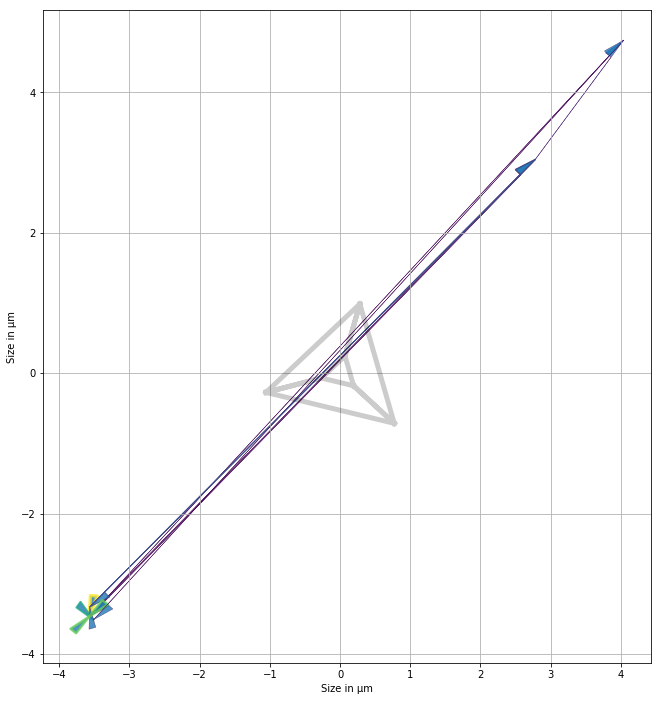

In [8]:
sym_organo = organo.copy()
coefs = _coef_matrix(sym_organo, 'areas')
constant = _right_side(sym_organo, coefs)
# DF_CONSTANT.to_csv('b_'+str(NF)+'cells.csv', index=False)
# RES_INFERENCE = _linear_model(ORGANO, 'areas')
# RES_INFERENCE = _qp_model(ORGANO, 'simple', True, 0)
res_inference = infer_forces(sym_organo, method='LINALG',
                             sup_param='areas', no_scale=False)
to_vect_res = np.hstack((res_inference['tensions'],
                         res_inference['areas']))
print(organo.vert_df.loc[:, ('x', 'y')])
print(organo.edge_df.loc[:, ('srce', 'trgt', 'length')])
print('A :\n', coefs)
print('b :', constant)
print('Ax*-b: ', np.dot(coefs, to_vect_res)-constant)
print('||Ax*-b||: ', np.linalg.norm(np.dot(coefs, to_vect_res) -
                                    constant))
print(res_inference)
sym_organo.edge_df.line_tension = prepare_tensions(sym_organo, res_inference['tensions'])
Solver.find_energy_min(sym_organo, geom, model)
print_tensions(sym_organo, organo)
print('Distance from th sym_organo to exp sym_organo : ' +
      str(np.sum(np.linalg.norm(_distance(sym_organo, organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(organo.edge_df.line_tension[:3*nb_cells] -
                                sym_organo.edge_df.line_tension[:3*nb_cells]))))

In [28]:
vert0 = (np.sum(coefs[0:organo.Nf, 0]), np.sum(coefs[2*organo.Nf:3*organo.Nf, 0]))
vert1 = (np.sum(coefs[0:organo.Nf, 1]), np.sum(coefs[2*organo.Nf:3*organo.Nf, 1]))
print(np.sum(coefs[:, 12]))
print(vert1)
for t in np.linspace(0, 2*np.pi, 1000):
    rot1 = np.dot([[np.cos(t), -np.sin(t)], [np.sin(t), np.cos(t)]], vert1)
    if abs(round(rot1[0], 2)) == abs(round(vert0[0], 2)) and abs(round(rot1[1], 2)) == abs(round(vert0[1], 2)):
        print(t)

0.0
(0.0, 0.0)
0.0
0.006289474781961547
0.012578949563923095
0.018868424345884642
0.02515789912784619
0.03144737390980774
0.037736848691769284
0.04402632347373083
0.05031579825569238
0.056605273037653926
0.06289474781961547
0.06918422260157703
0.07547369738353857
0.08176317216550011
0.08805264694746166
0.09434212172942322
0.10063159651138476
0.1069210712933463
0.11321054607530785
0.1195000208572694
0.12578949563923095
0.1320789704211925
0.13836844520315406
0.1446579199851156
0.15094739476707714
0.15723686954903868
0.16352634433100022
0.16981581911296179
0.17610529389492333
0.18239476867688487
0.18868424345884643
0.19497371824080797
0.20126319302276952
0.20755266780473106
0.2138421425866926
0.22013161736865416
0.2264210921506157
0.23271056693257725
0.2390000417145388
0.24528951649650035
0.2515789912784619
0.25786846606042346
0.264157940842385
0.27044741562434654
0.2767368904063081
0.2830263651882696
0.2893158399702312
0.2956053147521927
0.3018947895341543
0.30818426431611584
0.314473739

             x         y
vert                    
0     0.192932 -0.178306
1    -0.263550 -0.068212
2     0.070618  0.246518
3     0.771727 -0.713225
4    -1.054198 -0.272847
5     0.282472  0.986071
      srce  trgt    length
edge                      
0        0     1  0.469570
1        1     2  0.459045
2        2     0  0.442082
3        4     3  1.878280
4        5     4  1.836181
5        3     5  1.768326
6        3     0  0.788125
7        4     1  0.816701
8        5     2  0.769299
9        1     4  0.816701
10       2     5  0.769299
11       0     3  0.788125
A :
 [[-0.97212617  0.         -0.2766769   0.          0.          0.
   0.73439456  0.          0.          0.32250661  0.         -0.47987136
   0.03147295]
 [ 0.97212617  0.72796188  0.          0.          0.          0.
   0.         -0.96810035  0.         -0.04727018  0.25968221  0.
  -0.04248241]
 [ 0.         -0.72796188  0.2766769   0.          0.          0.
   0.          0.          0.27538522  0.        

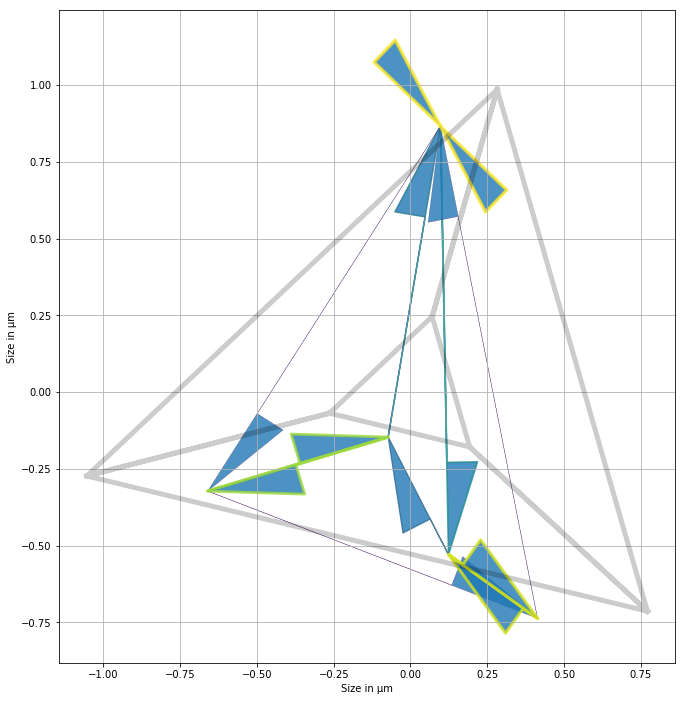

In [9]:
sym_organo = organo.copy()
coefs = _coef_matrix(sym_organo, 'areas')
constant = _right_side(sym_organo, coefs)
# DF_CONSTANT.to_csv('b_'+str(NF)+'cells.csv', index=False)
# RES_INFERENCE = _linear_model(ORGANO, 'areas')
# RES_INFERENCE = _qp_model(ORGANO, 'simple', True, 0)
res_inference = infer_forces(sym_organo, method='NNLS',
                             sup_param='areas', no_scale=False)
to_vect_res = np.hstack((res_inference['tensions'],
                         res_inference['areas']))
print(organo.vert_df.loc[:, ('x', 'y')])
print(organo.edge_df.loc[:, ('srce', 'trgt', 'length')])
print('A :\n', coefs)
print('b :', constant)
print('Ax*-b: ', np.dot(coefs, to_vect_res)-constant)
print('||Ax*-b||: ', np.linalg.norm(np.dot(coefs, to_vect_res) -
                                    constant))
print(res_inference)
sym_organo.edge_df.line_tension = prepare_tensions(sym_organo, res_inference['tensions'])
Solver.find_energy_min(sym_organo, geom, model)
print_tensions(sym_organo, organo)
print('Distance from th sym_organo to exp sym_organo : ' +
      str(np.sum(np.linalg.norm(_distance(sym_organo, organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(organo.edge_df.line_tension[:3*nb_cells] -
                                sym_organo.edge_df.line_tension[:3*nb_cells]))))

             x         y
vert                    
0     0.393047 -0.363252
1    -0.536912 -0.138963
2     0.143865  0.502215
3     0.786094 -0.726503
4    -1.073825 -0.277926
5     0.287730  1.004430
      srce  trgt    length
edge                      
0        0     1  0.956624
1        1     2  0.935183
2        2     0  0.900624
3        4     3  1.913249
4        5     4  1.870366
5        3     5  1.801248
6        3     0  0.535199
7        4     1  0.554604
8        5     2  0.522415
9        1     4  0.554604
10       2     5  0.522415
11       0     3  0.535199
A :
 [[-0.97212617  0.         -0.2766769   0.          0.          0.
   0.73439456  0.          0.        ]
 [ 0.97212617  0.72796188  0.          0.          0.          0.
   0.         -0.96810035  0.        ]
 [ 0.         -0.72796188  0.2766769   0.          0.          0.
   0.          0.          0.27538522]
 [ 0.          0.          0.         -0.97212617  0.         -0.2766769
  -0.73439456  0.          0.

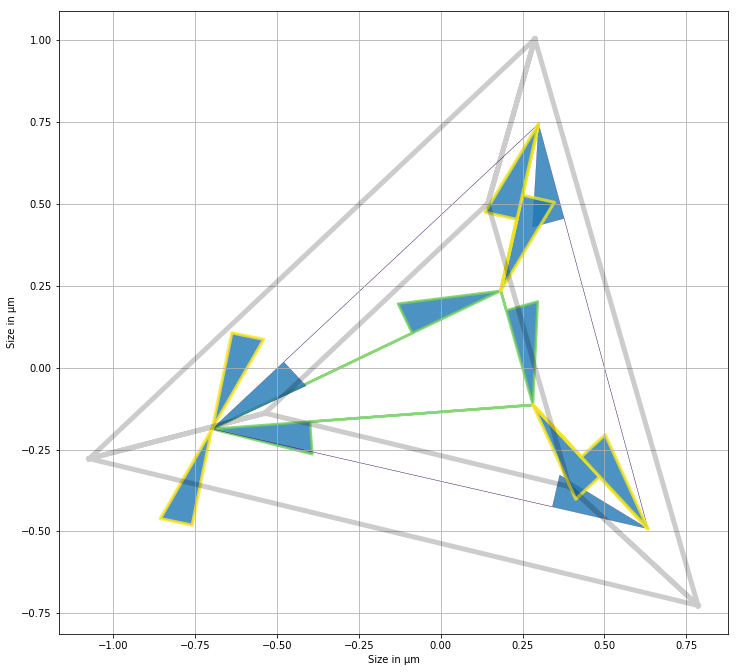

In [38]:
sym_organo = organo.copy()
coefs = _coef_matrix(sym_organo, '')
constant = _right_side(sym_organo, coefs)
# DF_CONSTANT.to_csv('b_'+str(NF)+'cells.csv', index=False)
# RES_INFERENCE = _linear_model(ORGANO, 'areas')
# RES_INFERENCE = _qp_model(ORGANO, 'simple', True, 0)
res_inference = infer_forces(sym_organo, method='NNLS',
                             sup_param='', no_scale=False)
to_vect_res = np.hstack((res_inference['tensions']))
print(organo.vert_df.loc[:, ('x', 'y')])
print(organo.edge_df.loc[:, ('srce', 'trgt', 'length')])
print('A :\n', coefs)
print('b :', constant)
print('Ax*-b: ', np.dot(coefs, to_vect_res)-constant)
print('||Ax*-b||: ', np.linalg.norm(np.dot(coefs, to_vect_res) -
                                    constant))
print(res_inference)
sym_organo.edge_df.line_tension = prepare_tensions(sym_organo, res_inference['tensions'])
Solver.find_energy_min(sym_organo, geom, model)
print_tensions(sym_organo, organo)
print('Distance from th sym_organo to exp sym_organo : ' +
      str(np.sum(np.linalg.norm(_distance(sym_organo, organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(organo.edge_df.line_tension[:3*nb_cells] -
                                sym_organo.edge_df.line_tension[:3*nb_cells]))))

In [31]:
seed = 1553
def create_sym_organo(seed, nb_cells, r_in, r_out):
    sym_organo = generate_ring(nb_cells, r_in, r_out)
    Nf= sym_organo.Nf
    geom.update_all(sym_organo)
    #alpha as proposed in the doc (in french) https://www.sharelatex.com/read/zdxptpnrryhc
    alpha = 1 + 1/(20*(sym_organo.settings['R_out']-sym_organo.settings['R_in']))


    # Model parameters or specifications
    specs = {
        'face':{
            'is_alive': 1,
            'prefered_area':  alpha*sym_organo.face_df.area, 
            'area_elasticity': 1.,},
        'edge':{        
            'ux': 0.,
            'uy': 0.,
            'uz': 0.,
            'line_tension': 0.1,
            'is_active': 1
            },
        'vert':{
            'adhesion_strength': 0.,
            'x_ecm': 0.,
            'y_ecm': 0.,
            'is_active': 1
            },
        'settings': {
            'lumen_elasticity': 0.1,
            'lumen_prefered_vol': sym_organo.settings['lumen_volume'],
            'lumen_volume': sym_organo.settings['lumen_volume']
            }
        }

    sym_organo.update_specs(specs, reset=True)
    normalize_scale(sym_organo, geom, refer='edges')
    geom.update_all(sym_organo)

    symetric_tensions = 10*set_init_point(sym_organo.settings['R_in'], sym_organo.settings['R_out'], sym_organo.Nf, alpha)
    sin_mul = 1+(np.sin(np.linspace(0, 2*np.pi, sym_organo.Nf, endpoint=False)))**2
    sym_organo.face_df.prefered_area *= np.random.normal(1.0, 0.05, sym_organo.Nf)
    sym_organo.edge_df.line_tension = prepare_tensions(sym_organo, symetric_tensions)
    sym_organo.edge_df.loc[:Nf-1, 'line_tension'] *= sin_mul*np.random.normal(1.0, 0.05, sym_organo.Nf)

    sym_organo.vert_df[['x_ecm', 'y_ecm']] = sym_organo.vert_df[['x', 'y']]

    sym_organo.vert_df.loc[sym_organo.basal_verts, 'adhesion_strength'] = 0.01

    new_tensions = sym_organo.edge_df.line_tension

    sym_organo.edge_df.loc[:,'line_tension'] = new_tensions

    res = Solver.find_energy_min(sym_organo, geom, model) 
    return sym_organo
sym_sym_organo = create_sym_organo(seed, 10, 110, 150)

Reseting datasets values with new specs


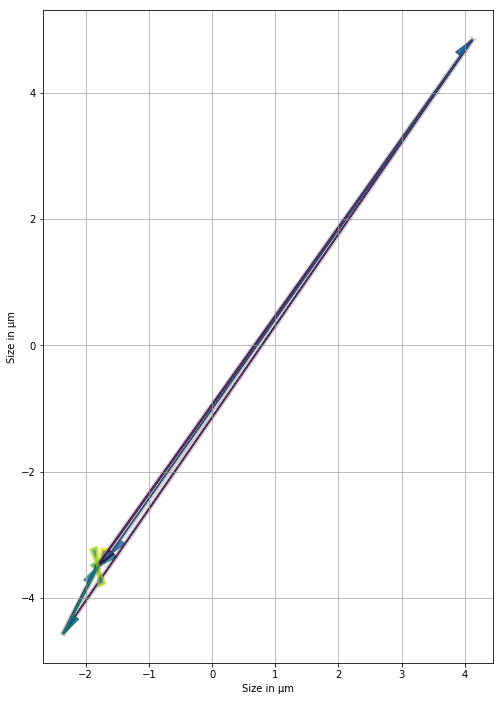

In [32]:
print_tensions(sym_organo, sym_organo)

             x         y
vert                    
0     0.393047 -0.363252
1    -0.536912 -0.138963
2     0.143865  0.502215
3     0.786094 -0.726503
4    -1.073825 -0.277926
5     0.287730  1.004430
      srce  trgt    length
edge                      
0        0     1  0.956624
1        1     2  0.935183
2        2     0  0.900624
3        4     3  1.913249
4        5     4  1.870366
5        3     5  1.801248
6        3     0  0.535199
7        4     1  0.554604
8        5     2  0.522415
9        1     4  0.554604
10       2     5  0.522415
11       0     3  0.535199
A :
 [[-0.97212617  0.         -0.2766769   0.          0.          0.
   0.73439456  0.          0.          0.2937701   0.         -0.61435908
   0.0641178 ]
 [ 0.97212617  0.72796188  0.          0.          0.          0.
   0.         -0.96810035  0.          0.04266269  0.39007056  0.
  -0.08654665]
 [ 0.         -0.72796188  0.2766769   0.          0.          0.
   0.          0.          0.27538522  0.        

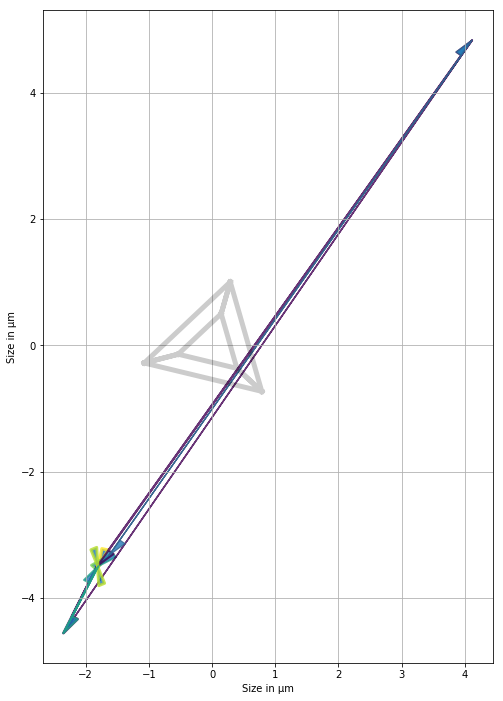

In [30]:
sym_organo = organo.copy()
coefs = _coef_matrix(sym_organo, 'areas')
constant = _right_side(sym_organo, coefs)
# DF_CONSTANT.to_csv('b_'+str(NF)+'cells.csv', index=False)
# RES_INFERENCE = _linear_model(ORGANO, 'areas')
# RES_INFERENCE = _qp_model(ORGANO, 'simple', True, 0)
res_inference = infer_forces(sym_organo, method='LINALG',
                             sup_param='areas', no_scale=False)
to_vect_res = np.hstack((res_inference['tensions'],
                         res_inference['areas']))
print(organo.vert_df.loc[:, ('x', 'y')])
print(organo.edge_df.loc[:, ('srce', 'trgt', 'length')])
print('A :\n', coefs)
print('b :', constant)
print('Ax*-b: ', np.dot(coefs, to_vect_res)-constant)
print('||Ax*-b||: ', np.linalg.norm(np.dot(coefs, to_vect_res) -
                                    constant))
print(res_inference)
organo.edge_df.line_tension = prepare_tensions(sym_organo, res_inference['tensions'])
Solver.find_energy_min(sym_organo, geom, model)
print_tensions(sym_organo, organo)

             x         y
vert                    
0     0.393047 -0.363252
1    -0.536912 -0.138963
2     0.143865  0.502215
3     0.786094 -0.726503
4    -1.073825 -0.277926
5     0.287730  1.004430
      srce  trgt    length
edge                      
0        0     1  0.956624
1        1     2  0.935183
2        2     0  0.900624
3        4     3  1.913249
4        5     4  1.870366
5        3     5  1.801248
6        3     0  0.535199
7        4     1  0.554604
8        5     2  0.522415
9        1     4  0.554604
10       2     5  0.522415
11       0     3  0.535199
A :
 [[-0.97212617  0.         -0.2766769   0.          0.          0.
   0.73439456  0.          0.          0.2937701   0.         -0.61435908
   0.0641178 ]
 [ 0.97212617  0.72796188  0.          0.          0.          0.
   0.         -0.96810035  0.          0.04266269  0.39007056  0.
  -0.08654665]
 [ 0.         -0.72796188  0.2766769   0.          0.          0.
   0.          0.          0.27538522  0.        

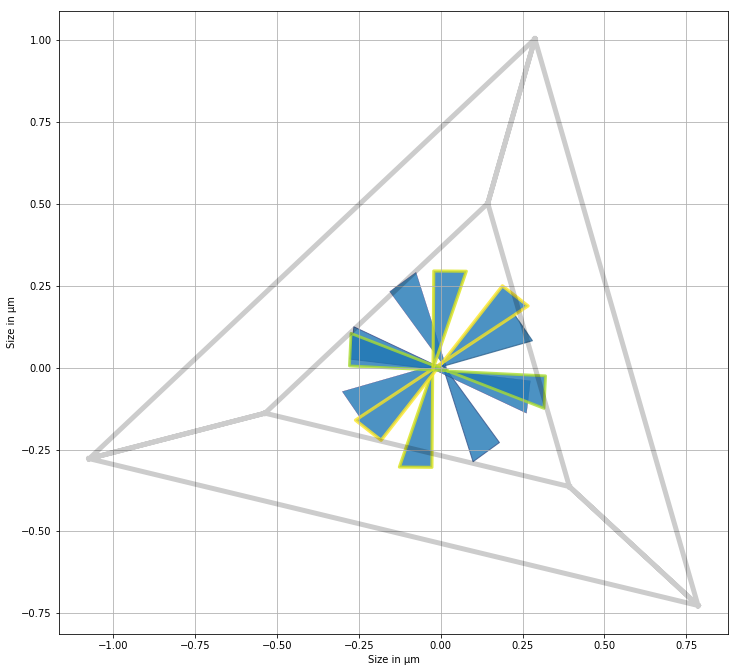

In [14]:
sym_organo = organo.copy()
coefs = _coef_matrix(sym_organo, 'areas')
constant = _right_side(sym_organo, coefs)
# DF_CONSTANT.to_csv('b_'+str(NF)+'cells.csv', index=False)
# RES_INFERENCE = _linear_model(ORGANO, 'areas')
# RES_INFERENCE = _qp_model(ORGANO, 'simple', True, 0)
res_inference = infer_forces(sym_organo, method='NNLS',
                             sup_param='areas', no_scale=False)
to_vect_res = np.hstack((res_inference['tensions'],
                         res_inference['areas']))
print(organo.vert_df.loc[:, ('x', 'y')])
print(organo.edge_df.loc[:, ('srce', 'trgt', 'length')])
print('A :\n', coefs)
print('b :', constant)
print('Ax*-b: ', np.dot(coefs, to_vect_res)-constant)
print('||Ax*-b||: ', np.linalg.norm(np.dot(coefs, to_vect_res) -
                                    constant))
print(res_inference)
organo.edge_df.line_tension = prepare_tensions(sym_organo, res_inference['tensions'])
Solver.find_energy_min(sym_organo, geom, model)
print_tensions(sym_organo, organo)

In [179]:
sym_organo = organo.copy()
coefs = _coef_matrix(sym_organo, '')
constant = _right_side(sym_organo, coefs)
# DF_CONSTANT.to_csv('b_'+str(NF)+'cells.csv', index=False)
# RES_INFERENCE = _linear_model(ORGANO, 'areas')
# RES_INFERENCE = _qp_model(ORGANO, 'simple', True, 0)
res_inference = infer_forces(sym_organo, method='NNLS',
                             sup_param='', no_scale=False)
to_vect_res = np.hstack((res_inference['tensions']))
print(organo.vert_df.loc[:, ('x', 'y')])
print(organo.edge_df.loc[:, ('srce', 'trgt', 'length')])
print('A :\n', coefs)
print('b :', constant)
print('Ax*-b: ', np.dot(coefs, to_vect_res)-constant)
print('||Ax*-b||: ', np.linalg.norm(np.dot(coefs, to_vect_res) -
                                    constant))
print(res_inference)
organo.edge_df.line_tension = prepare_tensions(sym_organo, res_inference['tensions'])
Solver.find_energy_min(sym_organo, geom, model)
print_tensions(sym_organo, organo)

array([ 0, 12, 15])

In [38]:
sym_organo.datasets['edge']['line_tension']

edge
0     0.065328
1     0.079342
2     0.096348
3     0.002293
4     0.000000
5     0.000000
6     0.186605
7     0.170261
8     0.199822
9     0.170261
10    0.199822
11    0.186605
Name: line_tension, dtype: float64

In [77]:
a = np.ones(15)
parameters = (('edge', 'line_tension'), ('face', 'prefered_area'))
split_inds = np.cumsum([sym_organo.datasets[elem][column].size for elem, column in parameters])
splitted_var = np.split(a, split_inds[:-1]) 

In [80]:
def prepare_params(organo, splitted_var, parameters):
    """Match the tension in a reduced array to an organo dataset

    Parameters
    ----------
    organo : :class:`Epithelium` object
    tension_array : vector of initial line tensions (size 3*Nf)

    Return
    ----------
    tensions : np.ndarray of size 4*Nf
    the tensions array properly organised to fit into an organo dataset
    """
    variables = {}
    for ind, (elem, param) in enumerate(parameters):
        if param == 'line_tension':
            variables[(elem, param)] = prepare_tensions(
                organo, splitted_var[ind])
        elif (param == 'prefered_area' and
              len(splitted_var[ind]) % organo.Nf != 0):
            variables[('lumen_prefered_vol', None)] = splitted_var[ind][-1]
            variables[(elem, param)] = splitted_var[ind][:-1]
        else:
            try:
                variables[(elem, param)] = splitted_var[ind]
            except KeyError as key_error:
                print('Called key is unknown too the datasets: ', key_error)
            except IndexError as ind_error:
                print('Not enougth indices in parameters vector: ', key_error)
    return variables

In [8]:
from tyssue_taylor.adjusters.adjust_annular import adjust_parameters

In [9]:
adjust_parameters(organo, , {}, lm_opt)

NameError: name 'initial_guess' is not defined

In [138]:
grad_calc = sym_organo.copy()
grad_calc.vert_df.loc[3, 'x'] += 0.001
geom.update_all(grad_calc)
print((grad_calc.face_df.area[0]-sym_organo.face_df.area[0])/0.001)

-0.04266268773323034


In [37]:
sym_organo.edge_df.loc[:, ('srce', 'trgt')]

,srce,trgt
edge,,
0,0,1
1,1,2
2,2,0
3,4,3
4,5,4
5,3,5
6,3,0
7,4,1
8,5,2


In [38]:
sym_organo.edge_df.loc[grad_trgt.index, 'face']

edge
0     0
1     1
2     2
3     0
4     1
5     2
6     0
7     1
8     2
9     0
10    1
11    2
Name: face, dtype: int64

In [39]:
sym_organo.edge_df.loc[grad_trgt.index, 'srce']

edge
0     0
1     1
2     2
3     4
4     5
5     3
6     3
7     4
8     5
9     1
10    2
11    0
Name: srce, dtype: int64

In [40]:
grad_trgt[sym_organo.edge_df.loc[grad_trgt.index, 'face']==0]

,gx,gy
edge,,
0,-0.006705,0.250473
3,-0.049367,-0.482963
6,0.174921,0.446997
9,-0.118849,-0.214507


In [41]:
grad_srce[sym_organo.edge_df.loc[grad_srce.index, 'srce']==0]

,gx,gy
edge,,
0,0.118849,0.214507
11,-0.415363,-0.191705


In [42]:
grad_srce[sym_organo.edge_df.loc[grad_srce.index, 'srce']==0]

,gx,gy
edge,,
0,0.118849,0.214507
11,-0.415363,-0.191705


In [43]:
adj_0 = pd.concat((grad_srce[sym_organo.edge_df.loc[grad_srce.index, 'srce']==0],
                   grad_trgt[sym_organo.edge_df.loc[grad_srce.index, 'trgt']==0]))

In [44]:
mat = np.zeros((sym_organo.Nv, sym_organo.Nf))

In [45]:
adj_0

,gx,gy
edge,,
0,0.118849,0.214507
11,-0.415363,-0.191705
2,-0.198996,-0.129410
6,0.174921,0.446997


In [46]:
grouped_srce.groups.keys()

NameError: name 'grouped_srce' is not defined

In [58]:
#%%timeit
#def _areas_coefs(sym_organo, no_scale):
vertex=0

grad_srce, grad_trgt = area_grad(sym_organo)
grad_lumen_srce, grad_lumen_trgt = lumen_area_grad(sym_organo)
grouped_srce = grad_srce.groupby(sym_organo.edge_df.srce)
grouped_trgt = grad_trgt.groupby(sym_organo.edge_df.trgt)
grouped_lumen_srce = grad_lumen_srce.groupby(sym_organo.edge_df.srce)
grouped_lumen_trgt = grad_lumen_trgt.groupby(sym_organo.edge_df.trgt)
area_coef = np.zeros((2*sym_organo.Nv, sym_organo.Nf+1))
for vertex in range(sym_organo.Nv):
    adj_srce = grouped_srce.get_group(list(grouped_srce.groups.keys())[vertex])
    adj_trgt = grouped_trgt.get_group(list(
        grouped_trgt.groups.keys())[vertex])[::-1]
    adj_lumen_srce = grouped_lumen_srce.get_group(list(
        grouped_lumen_srce.groups.keys())[vertex])
    adj_lumen_trgt = grouped_lumen_trgt.get_group(list(
        grouped_lumen_trgt.groups.keys())[vertex])[::-1]
    area_coef[vertex][sym_organo.edge_df.loc[
        adj_srce.index, 'face']] = adj_srce.gx.values + adj_trgt.gx.values
    area_coef[sym_organo.Nv+vertex][sym_organo.edge_df.loc[
        adj_srce.index, 'face']] = adj_srce.gy.values + adj_trgt.gy.values
    area_coef[vertex][sym_organo.Nf] = np.sum((adj_lumen_srce.gx,
                                               adj_lumen_trgt.gx))
    area_coef[sym_organo.Nv+vertex][sym_organo.Nf] = np.sum((adj_lumen_srce.gy,
                                                             adj_lumen_trgt.gy))

grad_factors = np.tile(sym_organo.face_df.area_elasticity, 2)

area_elasticity = np.tile(np.hstack([sym_organo.face_df.area_elasticity,
                                     sym_organo.settings['lumen_elasticity']]),
                          (2*sym_organo.Nv, 1))

area_coef *= area_elasticity
    
#    return area_coef

In [66]:
grouped_trgt.get_group(list(grouped_srce.groups.keys())[0])

,gx,gy
edge,,
2,-0.198996,-0.129410
6,0.174921,0.446997


In [65]:
grouped_srce.get_group(list(grouped_srce.groups.keys())[0]).index

Int64Index([0, 11], dtype='int64', name='edge')

In [81]:
sym_organo.edge_df.loc[grouped_srce.get_group(list(grouped_srce.groups.keys())[5]).index, ('srce', 'trgt', 'face')]

,srce,trgt,face
edge,,,
4,5,4,1
8,5,2,2


In [79]:
sym_organo.edge_df.loc[grouped_trgt.get_group(list(grouped_trgt.groups.keys())[5]).index, ('srce', 'trgt', 'face')]

,srce,trgt,face
edge,,,
5,3,5,2
10,2,5,1


In [351]:
#%%timeit
ind_dic = _indices_areas_coefs(sym_organo)  # coo_matrix indices
grad_srce, grad_trgt = area_grad(sym_organo)  # cell's areas gradient
grad_lumen_srce, grad_lumen_trgt = lumen_area_grad(sym_organo)  # lumen gradien
coef_shape = (sym_organo.apical_edges.shape[0], sym_organo.Nf+1)
coefs = _coefs_areas_coefs(sym_organo,
                           grad_srce, grad_trgt,
                           grad_lumen_srce, grad_lumen_trgt)
# print(coefs)
coef_x_apical = sparse.coo_matrix((coefs['api_x'],
                                   (ind_dic['api_cols'],
                                    ind_dic['api_rows'])),
                                  shape=(coef_shape))
coef_x_basal = sparse.coo_matrix((coefs['api_y'],
                                  (ind_dic['bas_cols'],
                                   ind_dic['bas_rows'])),
                                 shape=(coef_shape))
coef_y_apical = sparse.coo_matrix((coefs['bas_x'],
                                   (ind_dic['api_cols'],
                                    ind_dic['api_rows'])),
                                  shape=(coef_shape))
coef_y_basal = sparse.coo_matrix((coefs['bas_y'],
                                  (ind_dic['bas_cols'],
                                   ind_dic['bas_rows'])),
                                 shape=(coef_shape))
area_coefs = np.vstack((coef_x_apical.toarray(),
                        coef_x_basal.toarray(),
                        coef_y_apical.toarray(),
                        coef_y_basal.toarray()))

In [352]:
area_coefs

array([[-1.55962938,  0.        ,  3.11925876, -2.31089246],
       [ 8.91708573,  1.15544623,  0.        , -1.55962938],
       [ 0.        ,  1.15544623, -4.45854287, -4.45854287],
       [-2.93781692,  1.46890846,  0.        , -8.0262651 ],
       [ 0.        ,  2.15063125,  4.01313255,  1.46890846],
       [-1.07531563,  0.        ,  4.01313255, -1.07531563],
       [ 0.        ,  0.        ,  3.11925876, -2.31089246],
       [ 8.91708573,  0.        ,  0.        , -1.55962938],
       [ 0.        ,  1.15544623,  0.        , -4.45854287],
       [-2.93781692,  0.        ,  0.        , -8.0262651 ],
       [ 0.        ,  2.15063125,  0.        ,  1.46890846],
       [ 0.        ,  0.        ,  4.01313255, -1.07531563]])

In [375]:
sym_organo.edge_df.loc[:, ('srce', 'trgt', 'dx', 'length')]

,srce,trgt,dx,length
edge,,,,
0,0,1,-0.929960,0.956624
1,1,2,0.680778,0.935183
2,2,0,0.249182,0.900624
3,4,3,1.859919,1.913249
4,5,4,-1.361555,1.870366
5,3,5,-0.498364,1.801248
6,3,0,-0.393047,0.535199
7,4,1,0.536912,0.554604
8,5,2,-0.143865,0.522415


In [369]:
sym_organo.vert_df.loc[(0,1), :]

,y,is_active,x,segment,adhesion_strength,x_ecm,y_ecm
vert,,,,,,,
0,-0.363252,1,0.393047,apical,0.0,0.0,0.0
1,-0.138963,1,-0.536912,apical,0.0,0.0,0.0
